**Apogee Data Simple VAE Testing**

In [1]:
# Hardware check
!nvidia-smi

Tue Dec 14 23:54:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.76       Driver Version: 496.76       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   45C    P8    31W / 340W |    538MiB / 10240MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Basic imports
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from torch.optim import Adam

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

from astropy.io import fits

from matplotlib import pyplot as plt

In [3]:
# GPU verification
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
0
1
NVIDIA GeForce RTX 3080


**Hyperparameters**

In [4]:
# Hyperparameters
dataset_path = '~/datasets'
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

# Data parameters
input_rows = 20000   # Number of spectra to input
batch_size = 100    # Tested 100
validation_split = .2   # Fraction of dataset to reserve for test
random_seed = 42
np.random.seed(random_seed)
shuffle_toggle = False  # Redundant due to random reduced idx already implemented

# Model Dimensions
x_dim  = 7514
# Originally 400, 200
hidden_dim = 400
latent_dim = 28

# Learning rate
# Default 0.001
lr = 0.001

# VAE Beta
beta = 1

# Num epochs
epochs = 50

**Process and Load Data**

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
def starInfoDebug():
  for i in range(10):
      # Title information
      print("\n**************** Looking at index ", i, " ****************")
      print("APSTAR ID: ", star['apstar_id'][i],\
          "\nTARGET_ID: ", star['target_id'][i],\
              "\nASPCAP_ID: ", star['aspcap_id'][i])
      
      print("\nBasic Stats:")
      print("SNR: ", star['snr'][i])
      print("Effective Temp (K) \t ASPCAP: ", star['teff_spec'][i], 'AstroNN:', star_astroNN['TEFF'][i])
      print("Surface G (log(cm/s^2) \t ASPCAP: ", star['logg_spec'][i], 'AstroNN:', star_astroNN['LOGG'][i])

      #j = ind[i]
      j = i

      plt.subplot(5, 2, j+1)
      plt.title(star['aspcap_id'][i])
      plt.xlabel('Wavelength')
      plt.ylabel('Relative Flux')
      # 7514 data points for each spectra
      plt.plot(star_spectra[j])

      spectra_df = pd.DataFrame(star_spectra[j])
      # Actual input data
      print("\nInput dataframe:")
      print(spectra_df)

      #print(len(star_spectra[j]))
      #plt.legend([star['aspcap_id'][i]])
      #plt.show()

      # Abundances, other info
      print("\nAbundances, additional info (ASPCAP):")
      print(star['ra'][j], star['dec'][j], star['glon'][j], star['glat'][j],\
          star['vhelio_avg'][j], star['vscatter'][j],\
          star['teff'][j], star['teff_err'][j],\
          star['logg'][j], star['logg_err'][j],\
          star['m_h'][j], star['m_h_err'][j],\
          star['alpha_m'][j], star['alpha_m_err'][j],\
          star['c_fe'][j], star['c_fe_err'][j],\
          star['cI_fe'][j], star['cI_fe_err'][j],\
          star['n_fe'][j], star['n_fe_err'][j],\
          star['o_fe'][j], star['o_fe_err'][j],\
          star['na_fe'][j], star['na_fe_err'][j],\
          star['mg_fe'][j], star['mg_fe_err'][j],\
          star['al_fe'][j], star['al_fe_err'][j],\
          star['si_fe'][j], star['si_fe_err'][j],\
          star['p_fe'][j], star['p_fe_err'][j],\
          star['s_fe'][j], star['s_fe_err'][j],\
          star['k_fe'][j], star['k_fe_err'][j],\
          star['ca_fe'][j], star['ca_fe_err'][j],\
          star['ti_fe'][j], star['ti_fe_err'][j],\
          star['v_fe'][j], star['v_fe_err'][j],\
          star['cr_fe'][j], star['cr_fe_err'][j],\
          star['mn_fe'][j], star['mn_fe_err'][j],\
          star['fe_h'][j], star['fe_h_err'][j],\
          star['co_fe'][j], star['co_fe_err'][j],\
          star['ni_fe'][j], star['ni_fe_err'][j],\
          star['cu_fe'][j], star['cu_fe_err'][j],\
          star['ge_fe'][j], star['ge_fe_err'][j],\
          star['rb_fe'][j], star['rb_fe_err'][j],\
          star['aspcapflags'][j], star['starflags'][j])

      plt.subplots_adjust(hspace=1)
      #plt.tight_layout()
      plt.show()

In [7]:
print("\n ********************** Opening FITS files from drive **********************")

star_hdus = fits.open('allStar-r12-l33.fits')
astroNN_hdus = fits.open('apogee_astroNN-DR16-v1.fits')
star_spec = fits.open('contspec_dr16_final.fits')

star = star_hdus[1].data
star_astroNN = astroNN_hdus[1].data
star_spectra = star_spec[0].data

star_hdus.close()
astroNN_hdus.close()
star_spec.close()

print("Number of spectra: ", len(star))
print("Data points per spectra: ", len(star_spectra[1]))

# starInfoDebug()


 ********************** Opening FITS files from drive **********************
Number of spectra:  473307
Data points per spectra:  7514


**Load errors, good flags**

In [8]:
star_mask = fits.open('contspec_dr16_mask.fits')
star_err = fits.open('contspec_dr16_err.fits')

star_mask_data = star_mask[0].data
star_err_data = star_err[0].data

star_mask.close()
star_err.close()

print("Number of masks: ", len(star_mask_data))
print("Data points per maskk: ", len(star_mask_data[1]))

print("Number of errors: ", len(star_err_data))
print("Data points per error: ", len(star_err_data[1]))

Number of masks:  473307
Data points per maskk:  7514
Number of errors:  473307
Data points per error:  7514


**Data cuts, slices**

We only include stars with no bad star flags set, SNR > 200, 4000 < teff < 5500, and logg < 3.5.

In [9]:
# Further Star Analysis

from astropy.table import Table
dat = Table.read('allStar-r12-l33.fits', format='fits')
names = [name for name in dat.colnames if len(dat[name].shape) <= 1]
df = dat[names].to_pandas()
df.head()

,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,...,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,GAIA_RADIAL_VELOCITY,GAIA_RADIAL_VELOCITY_ERROR,GAIA_R_EST,GAIA_R_LO,GAIA_R_HI,TEFF_SPEC,LOGG_SPEC
0,b'apogee.apo1m.s.stars.calibration.VESTA',b'apo1m.1.calibration.VESTA',b'apogee.apo1m.s.r12-l33.calibration.VESTA',b'apStar-r12-VESTA.fits',b'VESTA',b'apo1m',1,b'calibration',-9999.990234,-9999.990234,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,5770.700195,4.49400
1,b'apogee.apo25m.s.stars.120+12.2M00000002+7417...,b'apo25m.5046.120+12.2M00000002+7417074',b'apogee.apo25m.s.r12-l33.120+12.2M00000002+74...,b'apStar-r12-2M00000002+7417074.fits',b'2M00000002+7417074',b'apo25m',5046,b'120+12',8.597000,0.039000,...,11.709962,13.291449,10.511990,-51.924661,0.365646,3285.226548,2959.076000,3687.594547,3628.600098,0.88758
2,b'apogee.apo25m.s.stars.060-75.2M00000019-1924...,b'apo25m.5071.060-75.2M00000019-1924498',b'apogee.apo25m.s.r12-l33.060-75.2M00000019-19...,b'apStar-r12-2M00000019-1924498.fits',b'2M00000019-1924498',b'apo25m',5071,b'060-75',11.074000,0.022000,...,12.187422,12.534893,11.669607,17.880444,2.120882,191.348325,156.570781,245.761634,5527.700195,4.23810
3,b'apogee.apo25m.s.stars.116-04.2M00000032+5737...,b'apo25m.4424.116-04.2M00000032+5737103',b'apogee.apo25m.s.r12-l33.116-04.2M00000032+57...,b'apStar-r12-2M00000032+5737103.fits',b'2M00000032+5737103',b'apo25m',4424,b'116-04',10.905000,0.023000,...,12.230203,12.671972,11.631516,-19.196012,1.356420,801.567552,780.757419,823.495963,6449.200195,4.01460
4,b'apogee.apo25m.s.stars.N7789.2M00000032+5737103',b'apo25m.4264.N7789.2M00000032+5737103',b'apogee.apo25m.s.r12-l33.N7789.2M00000032+573...,b'apStar-r12-2M00000032+5737103.fits',b'2M00000032+5737103',b'apo25m',4264,b'N7789',10.905000,0.023000,...,12.230203,12.671972,11.631516,-19.196012,1.356420,801.567552,780.757419,823.495963,6411.600098,3.97610


In [10]:
# Isolate critical columns
star_df = df[['APSTAR_ID', 'TEFF_SPEC', 'LOGG_SPEC', 'SNR', 'ASPCAPFLAGS', 'STARFLAGS']]
star_df

,APSTAR_ID,TEFF_SPEC,LOGG_SPEC,SNR,ASPCAPFLAGS,STARFLAGS
0,b'apogee.apo1m.s.stars.calibration.VESTA',5770.700195,4.49400,405.761993,b'',b''
1,b'apogee.apo25m.s.stars.120+12.2M00000002+7417...,3628.600098,0.88758,841.507019,b'',"b'PERSIST_MED,PERSIST_LOW'"
2,b'apogee.apo25m.s.stars.060-75.2M00000019-1924...,5527.700195,4.23810,188.955994,b'',b''
3,b'apogee.apo25m.s.stars.116-04.2M00000032+5737...,6449.200195,4.01460,120.471001,b'',"b'PERSIST_HIGH,SUSPECT_BROAD_LINES'"
4,b'apogee.apo25m.s.stars.N7789.2M00000032+5737103',6411.600098,3.97610,215.662994,b'',b'SUSPECT_BROAD_LINES'
...,...,...,...,...,...,...
473302,b'apogee.apo25m.s.stars.N188.2M23595756+8535275',5018.799805,4.48350,376.756012,b'',b'BRIGHT_NEIGHBOR'
473303,b'apogee.apo25m.s.stars.N7789.2M23595837+5700444',4927.500000,2.77310,91.416901,b'',b''
473304,b'apogee.apo25m.s.stars.060-75.2M23595886-2009...,5456.799805,4.20270,112.213997,b'',b''
473305,b'apogee.apo25m.s.stars.116-04.2M23595886+5726...,4806.399902,2.78250,202.197998,b'',"b'PERSIST_MED,PERSIST_LOW'"


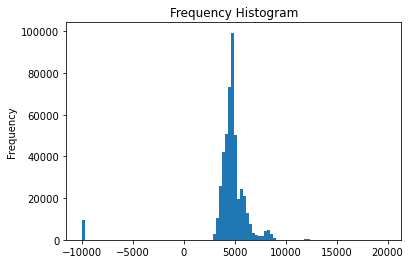

In [11]:
star_snr = star_df[["TEFF_SPEC"]]
plt.hist(star_snr, bins=100)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [12]:
#We only include stars with no bad star flags set, SNR > 200, 4000 < teff < 5500, and logg < 3.5.
star_df_best = star_df.loc[(star_df['TEFF_SPEC'] < 5500) & (star_df['TEFF_SPEC'] > 4000) & (star_df['LOGG_SPEC'] < 3.5) & (star_df['SNR'] > 200)]
star_df_best

,APSTAR_ID,TEFF_SPEC,LOGG_SPEC,SNR,ASPCAPFLAGS,STARFLAGS
18,b'apogee.apo25m.s.stars.120+08.2M00000866+7122...,4607.000000,2.7701,454.351990,b'',b''
23,b'apogee.apo25m.s.stars.116+00.2M00001199+6114...,4611.000000,2.6715,343.740997,b'',b''
28,b'apogee.apo25m.s.stars.N7789.2M00001328+5725563',4447.200195,2.4789,232.462997,b'',b''
34,b'apogee.apo25m.s.stars.N7789.2M00001653+5540107',4040.199951,1.7878,235.604004,b'',b''
37,b'apogee.apo25m.s.stars.116+00.2M00001717+6147...,4677.000000,2.5777,205.179001,b'',b'PERSIST_LOW'
...,...,...,...,...,...,...
473289,b'apogee.apo25m.s.stars.120+12.2M23595481+7509...,4742.500000,2.8883,467.380005,b'',b''
473290,b'apogee.apo25m.s.stars.N7789.2M23595490+5704387',5017.799805,3.2260,606.460999,b'',b''
473298,b'apogee.apo25m.s.stars.116+00.2M23595606+6251...,4198.600098,2.0426,314.253998,b'',b''
473301,b'apogee.apo25m.s.stars.120+18.2M23595676+7918...,4171.299805,1.9010,443.684998,b'',b''


Unique ASPCAP Flags

In [13]:
flagList = star_df_best['ASPCAPFLAGS'].unique()
for flag in flagList:
    print(flag.decode())


STAR_WARN,COLORTE_WARN
STAR_WARN,COLORTE_WARN,STAR_BAD,COLORTE_BAD
STAR_WARN,ROTATION_WARN,STAR_BAD,ROTATION_BAD
STAR_WARN,ROTATION_WARN
STAR_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD
STAR_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,COLORTE_BAD,ROTATION_BAD
STAR_WARN,ROTATION_WARN,STAR_BAD
STAR_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,ROTATION_BAD
STAR_BAD
STAR_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,COLORTE_BAD
STAR_WARN,COLORTE_WARN,STAR_BAD
STAR_WARN,CHI2_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,COLORTE_BAD,ROTATION_BAD
STAR_WARN,COLORTE_WARN,ROTATION_WARN
STAR_WARN,CHI2_WARN,ROTATION_WARN,STAR_BAD,CHI2_BAD,ROTATION_BAD
STAR_WARN,CHI2_WARN,STAR_BAD,CHI2_BAD
STAR_WARN,CHI2_WARN
STAR_WARN,CHI2_WARN,ROTATION_WARN,STAR_BAD,ROTATION_BAD
STAR_WARN,CHI2_WARN,COLORTE_WARN,ROTATION_WARN,STAR_BAD,CHI2_BAD,COLORTE_BAD,ROTATION_BAD
STAR_WARN,CHI2_WARN,ROTATION_WARN,STAR_BAD,CHI2_BAD


In [14]:
# Decode byte flags into strings
star_df_best['ASPCAPFLAGS'] = star_df_best['ASPCAPFLAGS'].str.decode("utf-8")

<ipython-input-14-e4f9950277f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star_df_best['ASPCAPFLAGS'] = star_df_best['ASPCAPFLAGS'].str.decode("utf-8")


In [15]:
# Strip out stars with STAR_BAD flag
star_df_best = star_df_best.loc[~(star_df_best['ASPCAPFLAGS'].str.contains("STAR_BAD"))]
star_df_best

,APSTAR_ID,TEFF_SPEC,LOGG_SPEC,SNR,ASPCAPFLAGS,STARFLAGS
18,b'apogee.apo25m.s.stars.120+08.2M00000866+7122...,4607.000000,2.7701,454.351990,,b''
23,b'apogee.apo25m.s.stars.116+00.2M00001199+6114...,4611.000000,2.6715,343.740997,,b''
28,b'apogee.apo25m.s.stars.N7789.2M00001328+5725563',4447.200195,2.4789,232.462997,,b''
34,b'apogee.apo25m.s.stars.N7789.2M00001653+5540107',4040.199951,1.7878,235.604004,,b''
37,b'apogee.apo25m.s.stars.116+00.2M00001717+6147...,4677.000000,2.5777,205.179001,,b'PERSIST_LOW'
...,...,...,...,...,...,...
473289,b'apogee.apo25m.s.stars.120+12.2M23595481+7509...,4742.500000,2.8883,467.380005,,b''
473290,b'apogee.apo25m.s.stars.N7789.2M23595490+5704387',5017.799805,3.2260,606.460999,,b''
473298,b'apogee.apo25m.s.stars.116+00.2M23595606+6251...,4198.600098,2.0426,314.253998,,b''
473301,b'apogee.apo25m.s.stars.120+18.2M23595676+7918...,4171.299805,1.9010,443.684998,,b''


Update the spectra dataframe with only 'good' indices

In [16]:
# Update the star_spectra dataframe with only 'good' indices
star_spectra = star_spectra[star_df_best.index]

# Update masks, errors as well
star_err_data = star_err_data[star_df_best.index]
star_mask_data = star_mask_data[star_df_best.index]


len(star_spectra)

73779

**Dataset Class for Spectral data**

In [17]:
# https://visualstudiomagazine.com/articles/2020/09/10/pytorch-dataloader.aspx

class spectraDataset(torch.utils.data.Dataset):

  # Num rows = max number of spectra to load
  def __init__(self, src, num_rows=None):
    if num_rows == None:
      spectra = src.astype(np.float32)
    else:
      spectra = src.astype(np.float32)[0:num_rows]

    # y_tmp = np.loadtxt(src_file, max_rows=num_rows,
    #   usecols=7, delimiter="\t", skiprows=0,
    #   dtype=np.long)

    self.x_data = torch.tensor(spectra, dtype=torch.float32).to(DEVICE)

    # self.y_data = T.tensor(y_tmp,
    #   dtype=T.long).to(DEVICE)

  def __len__(self):
    return len(self.x_data)  # required

  def __getitem__(self, idx):
    # if T.is_tensor(idx):
    #   idx = idx.tolist()
    # preds = self.x_data[idx, 0:7]
    # pol = self.y_data[idx]
    # sample = \
    #   { 'predictors' : preds, 'political' : pol }

    sample = self.x_data[idx]
    return sample

**Reduction & Train/Test Split**

In [18]:
# # Reduce the dataset down to a manageable size, based on input_rows hyperparameter
np.random.seed(random_seed)
random_reduced_idx = list(np.random.choice(len(star_spectra), input_rows, replace=False))

# # Grab only spectra with indices randomly selected from above
#reduced_star_spectra = np.take(star_spectra, random_reduced_idx, 0)
reduced_star_spectra = star_spectra[random_reduced_idx]
#print(pd.DataFrame(reduced_star_spectra))


# Normalize
for starRow in reduced_star_spectra:
    starRow -= starRow.min()
    #print(starRow.max())
    if starRow.max() == 0:
        print("Found zero max")
    else:
        starRow /= starRow.max()

print(pd.DataFrame(reduced_star_spectra))

Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
Found zero max
           0         1         2        

In [19]:
#Normalize (between 0 and 1)

# sum_of_rows = reduced_star_spectra.sum(axis=1)
# reduced_star_spectra = reduced_star_spectra / sum_of_rows[:, np.newaxis]

# reduced_maximum = np.amax(reduced_star_spectra)
# print(reduced_maximum)
# reduced_star_spectra = reduced_star_spectra/reduced_maximum

# Normalization array
# reduced_maximum = np.zeros(len(reduced_star_spectra))

# for i in range(0, len(reduced_star_spectra)):
#   reduced_maximum[i] = np.amax(reduced_star_spectra[i])
#   reduced_star_spectra[i] = reduced_star_spectra[i]/reduced_maximum[i]

# print(pd.DataFrame(reduced_star_spectra))

In [20]:
# Final normalized, reduced inputs
train_dataset = spectraDataset(reduced_star_spectra)
train_dataset[4000]

tensor([0.5920, 0.6778, 0.8080,  ..., 0.8827, 0.8701, 0.8635], device='cuda:0')

In [21]:
# Creating data indices for training and validation splits:
dataset_size = len(reduced_star_spectra)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

print("Splitting dataset at", split)

# If shuffling is enabled, use random seed to shuffle data indices
if shuffle_toggle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

# Get training/validation indices
train_indices, test_indices = indices[split:], indices[:split]

# Generate random samplers
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

Splitting dataset at 4000


In [22]:
print(train_dataset[4000])

tensor([0.5920, 0.6778, 0.8080,  ..., 0.8827, 0.8701, 0.8635], device='cuda:0')


In [23]:
# Generate data loaders
kwargs = {'num_workers': 0}
#kwargs = {'num_workers': 0} 

# train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, **kwargs)
# test_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler, **kwargs)

# Try without random sampling (simple split on index)
train_loader = DataLoader(train_dataset[split:], batch_size=batch_size, **kwargs)
test_loader = DataLoader(train_dataset[:split], batch_size=batch_size, **kwargs)

print('Batches in train:', len(train_loader))
print('Batches in test:', len(test_loader))

Batches in train: 160
Batches in test: 40


In [24]:
for idx, train in enumerate(train_loader):
    print(train.shape)
    print(train[0])

torch.Size([100, 7514])
tensor([0.5920, 0.6778, 0.8080,  ..., 0.8827, 0.8701, 0.8635], device='cuda:0')
torch.Size([100, 7514])
tensor([0.3198, 0.3116, 0.3225,  ..., 0.3147, 0.3133, 0.3129], device='cuda:0')
torch.Size([100, 7514])
tensor([0.6690, 0.6769, 0.7034,  ..., 0.6684, 0.6637, 0.6688], device='cuda:0')
torch.Size([100, 7514])
tensor([0.3386, 0.3470, 0.5938,  ..., 0.8324, 0.8443, 0.8315], device='cuda:0')
torch.Size([100, 7514])
tensor([0.8458, 0.8559, 0.8629,  ..., 0.8240, 0.8454, 0.8251], device='cuda:0')
torch.Size([100, 7514])
tensor([0.4989, 0.5101, 0.5532,  ..., 0.5645, 0.5394, 0.5283], device='cuda:0')
torch.Size([100, 7514])
tensor([0.6029, 0.6219, 0.6479,  ..., 0.6142, 0.6256, 0.6223], device='cuda:0')
torch.Size([100, 7514])
tensor([0.5590, 0.5657, 0.5943,  ..., 0.6623, 0.6445, 0.6399], device='cuda:0')
torch.Size([100, 7514])
tensor([0.7279, 0.7579, 0.8378,  ..., 0.8594, 0.8563, 0.8384], device='cuda:0')
torch.Size([100, 7514])
tensor([0.6796, 0.6878, 0.7384,  ..., 0.

In [25]:
# MNIST Testing data

# mnist_transform = transforms.Compose([
#         transforms.ToTensor(),
# ])

# kwargs = {'num_workers': 1, 'pin_memory': True} 

# train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
# test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
# test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

Implement Simple VAE

In [26]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()

    # FC Linear version
    self.FC_input = nn.Linear(input_dim, 3757)
    # Try batch normalization
    # nn.BatchNorm1d(hidden_dim)
    self.FC_input2 = nn.Linear(3757, 1878)
    self.FC_input3 = nn.Linear(1878, 939)
    self.FC_input4 = nn.Linear(939, 469)
    self.FC_input5 = nn.Linear(469, 234)
    self.FC_input6 = nn.Linear(234, 117)
    self.FC_input7 = nn.Linear(117, 58)
    # self.FC_input8 = nn.Linear(58, 29)

    # Increase number of layers!!

    # Mean and log variance
    self.FC_mean  = nn.Linear(58, latent_dim)
    self.FC_var   = nn.Linear(58, latent_dim)
    
    self.LeakyReLU = nn.LeakyReLU()
    self.gelu = torch.nn.GELU()
    
    self.training = True
      
  def forward(self, x):
    h_ = self.gelu(self.FC_input(x))
    h_ = self.gelu(self.FC_input2(h_))
    h_ = self.gelu(self.FC_input3(h_))
    h_ = self.gelu(self.FC_input4(h_))
    h_ = self.gelu(self.FC_input5(h_))
    h_ = self.gelu(self.FC_input6(h_))
    h_ = self.gelu(self.FC_input7(h_))
    # h_ = self.LeakyReLU(self.FC_input8(h_))

    mean = self.FC_mean(h_)
    log_var = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                  #             (i.e., parameters of simple tractable normal distribution "q"
    
    return mean, log_var

In [27]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()

    # FC Linear version
    # self.FC_hidden = nn.Linear(latent_dim, 29)
    self.FC_hidden2 = nn.Linear(latent_dim, 58)
    self.FC_hidden3 = nn.Linear(58, 117)
    self.FC_hidden4 = nn.Linear(117, 234)
    self.FC_hidden5 = nn.Linear(234, 469)
    self.FC_hidden6 = nn.Linear(469, 939)
    self.FC_hidden7 = nn.Linear(939, 1878)
    self.FC_hidden8 = nn.Linear(1878, 3757)
    self.FC_output = nn.Linear(3757, output_dim)
    
    self.LeakyReLU = nn.LeakyReLU()
    self.gelu = torch.nn.GELU()

  def forward(self, x):
    # h = self.LeakyReLU(self.FC_hidden(x))
    h = self.gelu(self.FC_hidden2(x))
    h = self.gelu(self.FC_hidden3(h))
    h = self.gelu(self.FC_hidden4(h))
    h = self.gelu(self.FC_hidden5(h))
    h = self.gelu(self.FC_hidden6(h))
    h = self.gelu(self.FC_hidden7(h))
    h = self.gelu(self.FC_hidden8(h))
  
    # originally torch.sigmoid, but output range incorrect
    # Replace with smooth function - look into this!!
    # Softplus, gelu 

    #activation = torch.nn.Softplus()
    activation = torch.nn.GELU()
    x_hat = activation(self.FC_output(h))
    #x_hat = torch.nn.GELU(self.FC_output(h))
    #print(x_hat)
    return x_hat

**Re-run from this point to retrain**

In [174]:
class Model(nn.Module):
  def __init__(self, Encoder, Decoder):
    super(Model, self).__init__()
    self.Encoder = Encoder
    self.Decoder = Decoder

  def reparameterization(self, mean, var):
    epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
    z = mean + var*epsilon                          # reparameterization trick
    return z
              
  def forward(self, x):
    # Generate mean, log var
    mean, log_var = self.Encoder(x)

    z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
    x_hat = self.Decoder(z)
    
    return x_hat, mean, log_var

In [175]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

**Pixel bitmask**

https://arxiv.org/pdf/1706.00009.pdf

https://www.sdss.org/dr14/algorithms/bitmasks/


0 Pixel marked as bad according to bad pixel mask

1 Pixel struck by cosmic ray

2 Pixel saturated

3 Pixel marked as unfixable

4 Pixel marked as bad according to dark frame

5 Pixel marked as bad according to flat frame

6 Pixel set to have a very high error

7 No sky available for this pixel from sky fibers

12 Pixel falls near sky line

In [176]:
def bitmask_boolean(bitmask, target_bit):
    """
    Turn bitmask to boolean with provided bitmask array and target bit to mask

    :param bitmask: bitmask
    :type bitmask: ndarray
    :param target_bit: target bit to mask
    :type target_bit: list[int]
    :return: boolean array, True for clean, False for masked
    :rtype: ndarray[bool]
    :History: 2018-Feb-03 - Written - Henry Leung (University of Toronto)
    """
    target_bit = np.array(target_bit)
    target_bit = np.sum(2 ** target_bit)
    bitmask = np.atleast_2d(bitmask)

    # Modified dtype = bool to dtype = int to get 1s or 0s
    # 0 = has a bad bit, 1 = good
    boolean_output = np.ones(bitmask.shape, dtype=int)
    boolean_output[(bitmask & target_bit) != 0] = 0
    return boolean_output

In [177]:
star_mask_data[0:10]

array([[    0,     0,     0, ...,     0,     0,     0],
       [ 8192,  8192,  8192, ...,  2048,  2048,     0],
       [ 8192,  8192,  8192, ...,     0,     0,     0],
       ...,
       [  512,   512,   512, ...,     0,     0,     0],
       [ 1024,  1024,  1024, ...,     0,     0,     0],
       [16417, 16417, 16417, ...,     0,     0,     0]], dtype=int64)

In [178]:
bitmask_boolean(star_mask_data[0:10], [0, 1, 2, 3, 4, 5, 6, 7, 12])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [179]:
import math

def loss_function(x, x_hat, mean, log_var, originalIndex, batch_size):

    # sum_ij ((data_ij-model_ij)^2/error_ij^2 * goodflag_ij)
    # where the error is the new errors from the files and goodflag 
    # should be set to 1/0 following Henry's flags/code

    good_flag_array = torch.from_numpy(bitmask_boolean(star_mask_data[originalIndex : originalIndex + batch_size], [0, 1, 2, 3, 4, 5, 6, 7, 12])).to(DEVICE)

    # Convert to float32 to avoid byte ordering issues, send to GPU
    errors_for_batch = torch.from_numpy(star_err_data[originalIndex : originalIndex + batch_size].astype(np.float32)).to(DEVICE)
    errors_for_batch = errors_for_batch**2
    # Set all zero errors to 1 to prevent overflow
    errors_for_batch[errors_for_batch==0] = 1
    # Basic reproduction difference tensor
    reproduction_loss = (x_hat - x)**2

    # print("x_hat first row", x_hat[0])
    # print("x first row", x[0])
    # print("(x_hat - x)^2 first row", reproduction_loss[0])
    # print("star error first row", errors_for_batch[0])

    # Divide row of reproduction tensor by row of error tensor
    for idx in range(len(reproduction_loss)):
        # print("MAX REPRO",torch.max(reproduction_loss[idx]))
        # print("MIN REPRO",torch.min(reproduction_loss[idx]))

        # print("MAX ERROR",torch.max(errors_for_batch[idx]))
        # print("MIN ERROR",torch.min(errors_for_batch[idx]))
        # print("MIN ERROR IDX",torch.argmin(errors_for_batch[idx]))

        reproduction_loss[idx] = torch.div(reproduction_loss[idx], errors_for_batch[idx])

        if math.inf in reproduction_loss[idx]:
            print("\n************************INF DETECTED, break\n")
            print("Error at row", idx)
            break

    # reproduction_loss = torch.div(reproduction_loss, errors_for_batch)

    # Mask out bad bits using good flags
    reproduction_loss = reproduction_loss * good_flag_array

    # Get final reproduction loss using reduction method (sum)
    reproduction_loss_final = torch.sum(reproduction_loss)

    #print((x_hat - x)**2)
    #print("x_hat", (x_hat - x)**2)
    # print("reproduction loss first row", torch.div((x_hat - x)[0]**2, errors_for_batch[0]**2))

    # print("reproduction loss final:")
    # print(reproduction_loss_final)

    # print("*"*25)

    # Reduction = mean or sum
    #reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')

    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss_final + beta * KLD

**Run Training**

In [180]:
#optimizer = Adam(model.parameters(), lr=lr)
optimizer = Adam(model.parameters(), lr=lr, amsgrad=True)

# Dynamic LR decay
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [181]:
# Loss arrays
train_losses = []
val_losses = []

print("Start training VAE...")
model.train()

for epoch in range(epochs):
  overall_loss = 0
  
  for batch_idx, (x) in enumerate(train_loader):
    x = x.view(batch_size, x_dim)
    x = x.to(DEVICE)
    
    # Original index of batch sample in train dataset
    originalIndex = batch_idx * batch_size + split

    optimizer.zero_grad()

    x_hat, mean, log_var = model(x)
    loss = loss_function(x, x_hat, mean, log_var, originalIndex, batch_size)
    
    overall_loss += loss.item()
    
    loss.backward()
    optimizer.step()
  
  # Dynamic LR decay
  # scheduler.step()

  avgLoss = overall_loss / (batch_idx*batch_size)
  train_losses.append(avgLoss)
  print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", avgLoss)
    
print("Finished!!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  40311604012434.05
	Epoch 2 complete! 	Average Loss:  5948021.3655345915
	Epoch 3 complete! 	Average Loss:  4224596.64
	Epoch 4 complete! 	Average Loss:  3021760.651572327
	Epoch 5 complete! 	Average Loss:  3740794.958490566
	Epoch 6 complete! 	Average Loss:  4423175.7283018865
	Epoch 7 complete! 	Average Loss:  3799991.8671698114
	Epoch 8 complete! 	Average Loss:  2780743.7901886795
	Epoch 9 complete! 	Average Loss:  2841563.982389937
	Epoch 10 complete! 	Average Loss:  3269337.4525786163
	Epoch 11 complete! 	Average Loss:  5810982.471446541
	Epoch 12 complete! 	Average Loss:  2986362.0342138363
	Epoch 13 complete! 	Average Loss:  2866252.5283018867
	Epoch 14 complete! 	Average Loss:  2906199.70163522
	Epoch 15 complete! 	Average Loss:  2637609.5119496854
	Epoch 16 complete! 	Average Loss:  2602136.8498113207
	Epoch 17 complete! 	Average Loss:  2809944.0110691823
	Epoch 18 complete! 	Average Loss:  3466973.0586163523
	Epoch 19 co

**Validation - Print Test Loss**

In [182]:
model.eval()
test_losses = []

with torch.no_grad():
  for batch_idx, (x) in enumerate(tqdm(test_loader)):
    x = x.view(batch_size, x_dim)
    x = x.to(DEVICE)

    # Original index of batch sample in train dataset
    originalIndex = batch_idx * batch_size

    
    x_hat, mean, log_var = model(x)
    
    loss = loss_function(x, x_hat, mean, log_var, originalIndex, batch_size)
    avgLoss = loss.item()/batch_size
    #print("Test Loss", avgLoss)

    test_losses.append(avgLoss)

100%|██████████| 40/40 [00:00<00:00, 58.00it/s]


In [183]:
print("Average Test Loss:",sum(test_losses)/len(test_losses))

Average Test Loss: 2658350.644


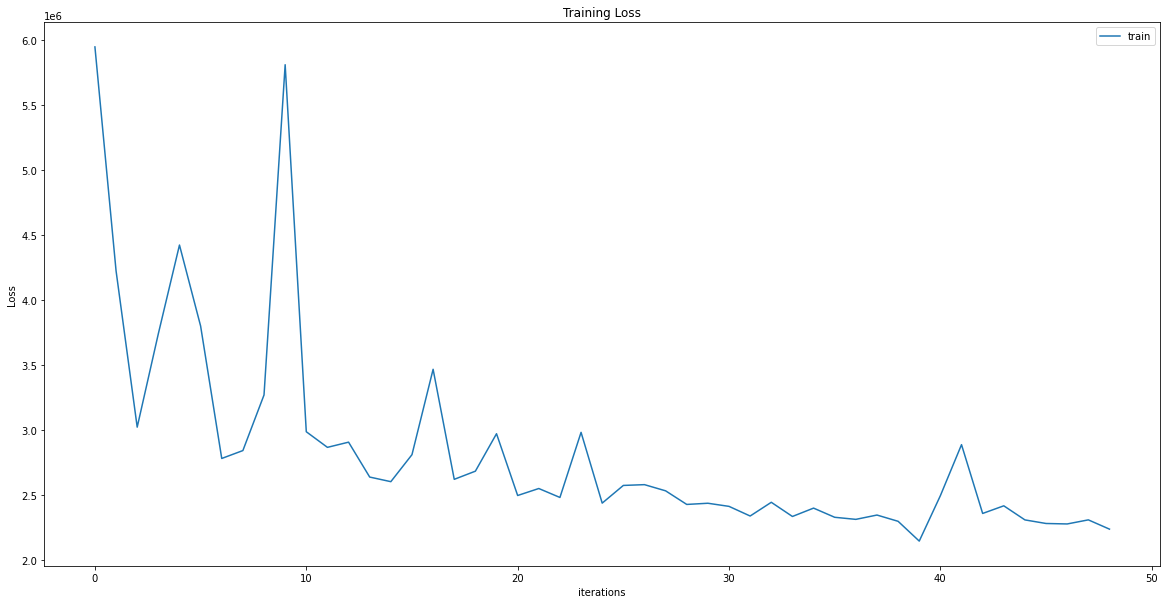

In [184]:
# Plot losses

plt.figure(figsize=(20,10))
plt.title("Training Loss")
# plt.plot(val_losses,label="val")
# Strip out first epoch, due to huge value
plt.plot(train_losses[1:],label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

tensor([0.8039, 0.7964, 0.8376,  ..., 0.8398, 0.8365, 0.8049], device='cuda:0')


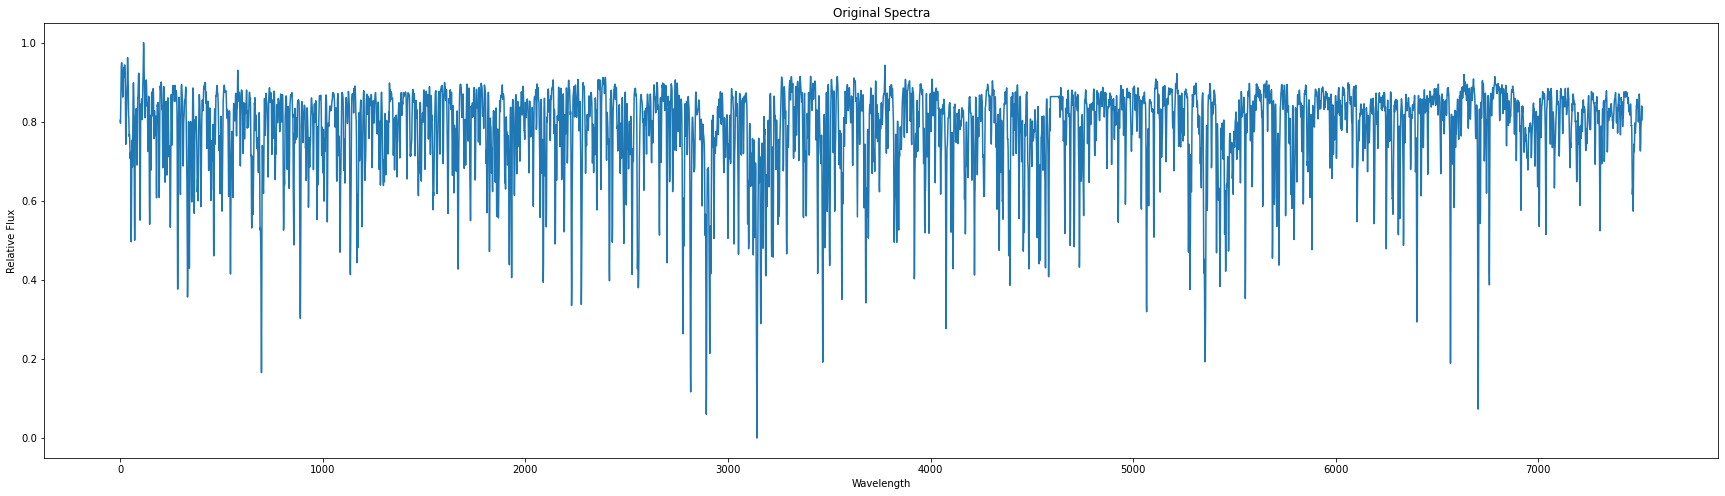

In [185]:
#x[1] = x[1] * reduced_maximum
print(x[0])
plt.rcParams["figure.figsize"] = (30,8)
plt.title('Original Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Relative Flux')
# 7514 data points for each spectra
plt.plot(x[0].cpu().numpy())
plt.show()

tensor([0.7350, 0.7650, 0.8164,  ..., 0.8225, 0.8034, 0.7682], device='cuda:0')


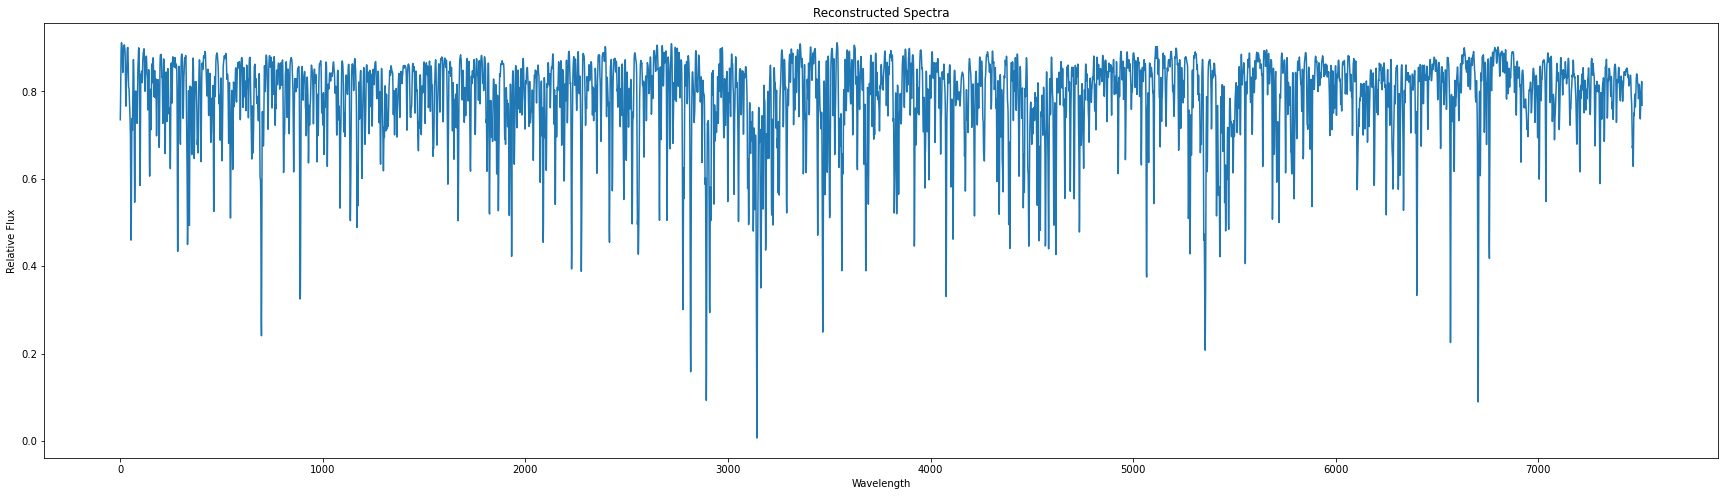

In [186]:
#x_hat[1] = x_hat[1] * reduced_maximum

print(x_hat[0])
plt.rcParams["figure.figsize"] = (30,8)
plt.title('Reconstructed Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Relative Flux')
# 7514 data points for each spectra
plt.plot(x_hat[0].cpu().numpy())
plt.show()

tensor([0.7350, 0.7650, 0.8164,  ..., 0.8225, 0.8034, 0.7682], device='cuda:0')


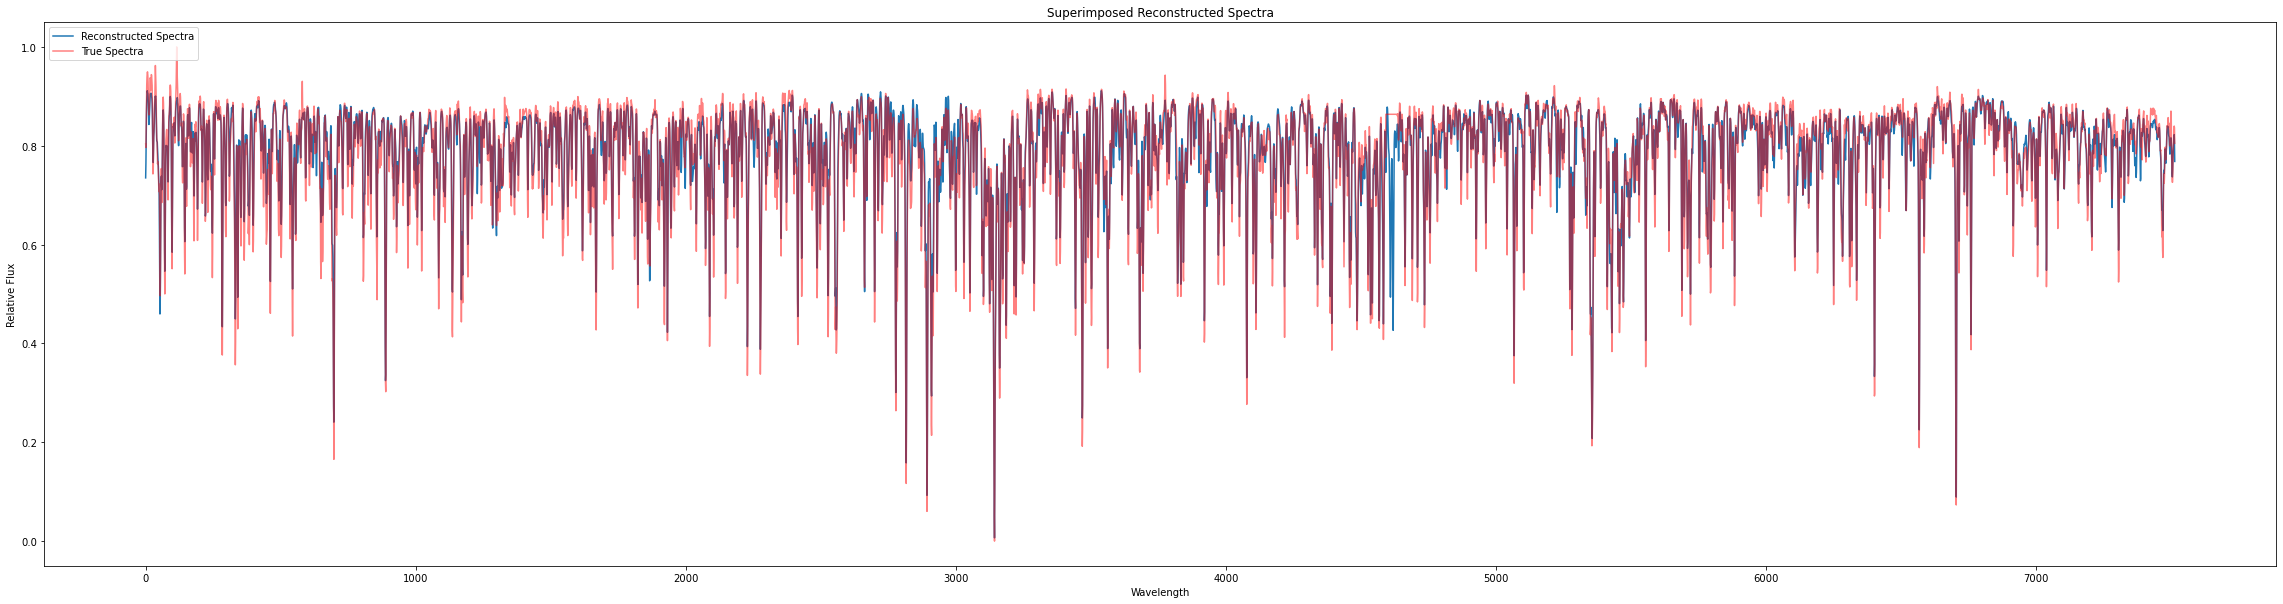

In [187]:
# Superimposed plot

print(x_hat[0])
plt.rcParams["figure.figsize"] = (40,10)
plt.title('Superimposed Reconstructed Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Relative Flux')
# 7514 data points for each spectra
plt.plot(x_hat[0].cpu().numpy(), label="Reconstructed Spectra")
plt.plot(x[0].cpu().numpy(), 'r-', alpha=0.5, label="True Spectra")
plt.legend(loc="upper left")

plt.show()

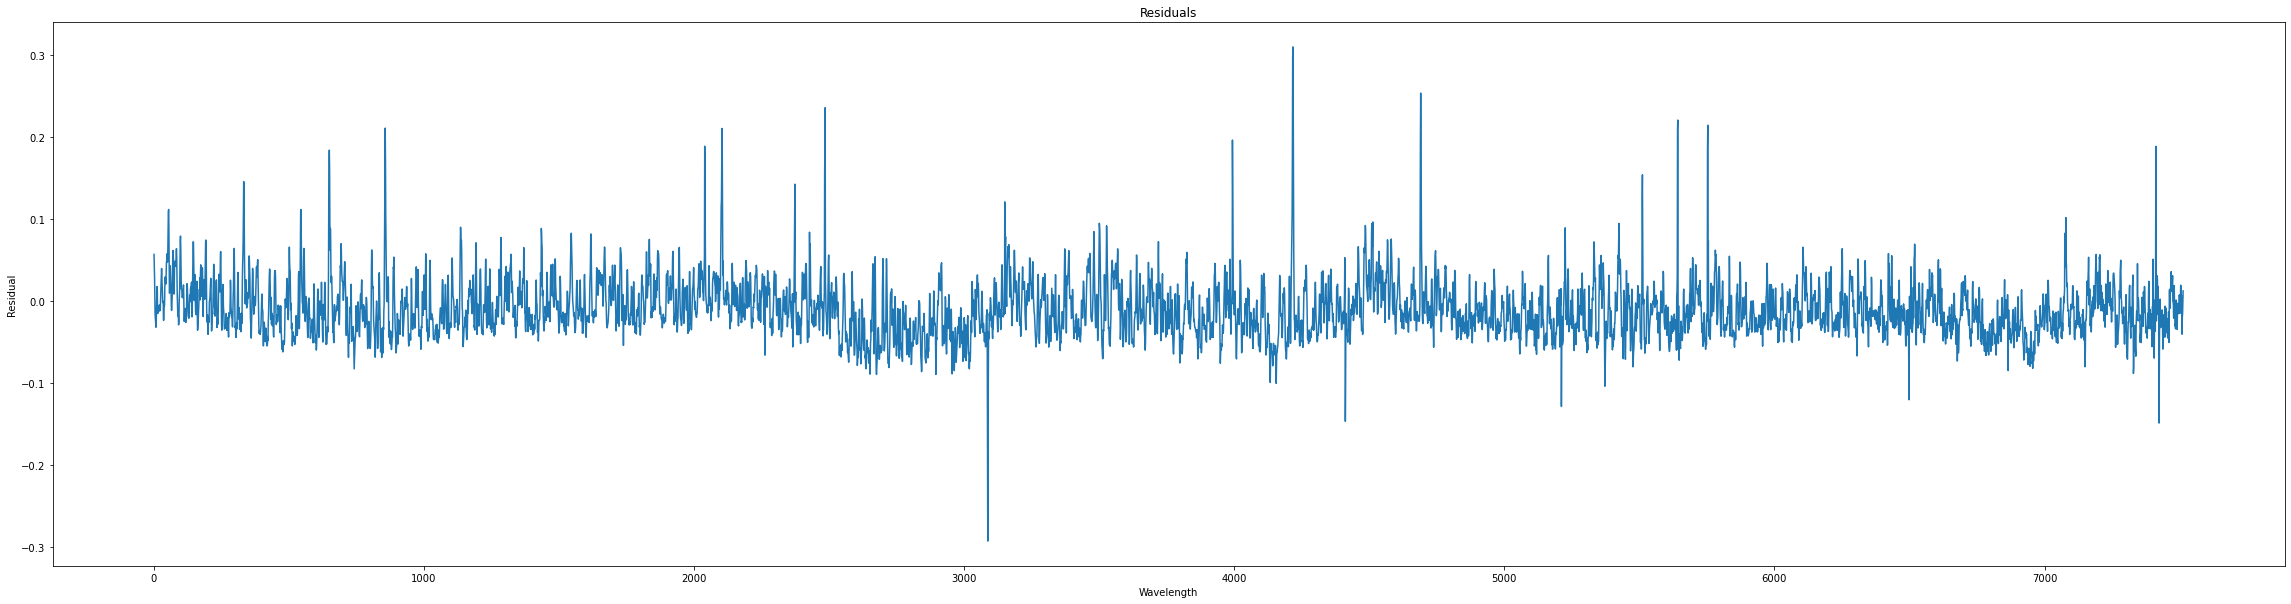

In [188]:
# Residuals plot 
residuals = x[2].cpu().numpy() - x_hat[2].cpu().numpy()
plt.title('Residuals')
plt.xlabel('Wavelength')
plt.ylabel('Residual')
# 7514 data points for each spectra
plt.plot(residuals, label="Residual")

In [189]:
print(encoder.FC_mean.weight)

Parameter containing:
tensor([[ 0.0190, -0.0989,  0.0635,  ..., -0.1426,  0.0735, -0.0004],
        [ 0.0794,  0.0880, -0.0907,  ..., -0.0691,  0.0884,  0.1002],
        [-0.1146,  0.1183,  0.0714,  ..., -0.0184,  0.0147, -0.0766],
        ...,
        [-0.0925,  0.1009, -0.0391,  ..., -0.0322,  0.0880, -0.1118],
        [-0.0397,  0.0156,  0.0406,  ...,  0.0829,  0.1253, -0.0314],
        [-0.0266, -0.0624,  0.0129,  ...,  0.1143,  0.0688,  0.1234]],
       device='cuda:0', requires_grad=True)


In [190]:
print(encoder.FC_var.weight)

Parameter containing:
tensor([[ 0.0030, -0.0338, -0.0419,  ..., -0.0460,  0.0199,  0.0121],
        [ 0.0791,  0.0878, -0.0097,  ...,  0.0563, -0.0513, -0.0309],
        [-0.0035,  0.0344,  0.1079,  ...,  0.0192,  0.0559, -0.0694],
        ...,
        [-0.0417,  0.0526,  0.0974,  ...,  0.0481, -0.1042, -0.0182],
        [-0.1447,  0.0052,  0.0597,  ...,  0.0597, -0.1133, -0.1304],
        [-0.1336,  0.0378,  0.1231,  ...,  0.0663,  0.1138,  0.0203]],
       device='cuda:0', requires_grad=True)


# Check out corner.py